# SCANIA Trucks APS Failure Prediction

# 1. Introduction

Air Pressure System (APS) in trucks generates pressurized air that is used for various functions
of trucks such as braking and gear changes. Lot of money is spent on un-necessary checks done
by service person on APS system in trucks, which can be prevented by developing a machine
learning model that can predict the failure of component in APS. In this way, service can be
restricted to the trucks whose APS component is predicted to be failed by the model.

The given dataset positive class consists of component failures for a specific component of the
APS system. The negative class consists of trucks with failures for components not related to the
APS. Attributes of dataset are anonymized for proprietary reasons. This is a binary classification
problem.

### Challenge metric

Cost-metric of miss-classification:

Given, Cost_1 = 10 and cost_2 = 500
The total cost of a prediction model the sum of 'Cost_1'
multiplied by the number of Instances with type 1 failure
and 'Cost_2' with the number of instances with type 2 failure,
resulting in a 'Total_cost'.

In this case Cost_1 refers to the cost that an unnessecary
check needs to be done by an mechanic at an workshop, while
Cost_2 refer to the cost of missing a faulty truck,
which may cause a breakdown.

#### Total_cost = Cost_1 times No_Instances with type 1 + Cost_2 times No_Instances with type2.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import re
import os
import datetime as dt
import pickle
from datetime import datetime
from scipy import stats
import random
from sklearn.model_selection import KFold
from IPython.display import display, Markdown
import pickle
from pandas import Series
from collections import defaultdict
import math
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import f1_score, auc, accuracy_score, recall_score, precision_score,\
confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


For Exploratory Data Analysis please refer SCANIA_APS_Failure_Prediction-Final-EDA file

## 2. Read Dataset

In [2]:
#Read train and test data
train = pd.read_csv('aps_failure_training_set.csv')
test = pd.read_csv("aps_failure_test_set.csv")

# 3. Data Preprocessing

## 3.1 Train Dataset

In [3]:
# Replacing the na and nan values with np.NaN
train.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [4]:
# Encoding negative class as 0 and positive class as 1
labels = []
for x in train['class']:
    if x == 'neg':
        labels.append(0)
    else:
        labels.append(1)
        
train['class'] = labels

In [5]:
y_train = train['class']
train.drop(['class'],axis = 1,inplace = True)

In [6]:
#Remove the column if the missing values are more than 70% (42000) in that column
train.dropna(axis = 1, thresh=42000,inplace= True)

In [7]:
train.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,2130706438,280,0,0,0,0,0,0,37250,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,33058,0,NaN,0,0,0,0,0,0,18254,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,41040,228,100,0,0,0,0,0,0,1648,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,12,70,66,0,10,0,0,0,318,2212,...,240,46,58,44,10,0,0,0,4,32
4,60874,1368,458,0,0,0,0,0,0,43752,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


## 3.2 Test Dataset

In [8]:
# Replacing the na and nan values with np.NaN
test.replace(to_replace=['na','nan'],value = np.NaN,inplace=True)

In [9]:
# Encoding negative class as 0 and positive class as 1
labels = []
for x in test['class']:
    if x == 'neg':
        labels.append(0)
    else:
        labels.append(1)
        
test['class'] = labels

In [10]:
y_test = test['class']
test.drop(['class'],axis = 1,inplace = True)

In [11]:
#Remove the column if the missing values are more than 70% (11200) in that column
test.dropna(axis = 1, thresh=11200,inplace= True)

In [12]:
test.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,20,12,0,0,0,0,0,2682,4736,...,1098,138,412,654,78,88,0,0,0,0
1,82,68,40,0,0,0,0,0,0,748,...,1068,276,1620,116,86,462,0,0,0,0
2,66002,212,112,0,0,0,0,0,199486,1358536,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,59816,1010,936,0,0,0,0,0,0,123922,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,1814,156,140,0,0,0,0,0,0,72,...,7646,4144,18466,49782,3176,482,76,0,0,0


# 4. Handling Missing Values - Median,Mean and Most_Frequent Value Imputation

In [44]:
#Impute median values of column to missing in the column 
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
impute_median = SimpleImputer(missing_values= np.nan, strategy='median',copy = True, verbose= 2)
train_median_imputed = pd.DataFrame(impute_median.fit_transform(train),columns=train.columns)
test_median_imputed = pd.DataFrame(impute_median.transform(test),columns=test.columns)

In [13]:
#Impute mean values of column to missing in the column 
impute_mean = SimpleImputer(missing_values= np.nan, strategy='mean',copy = True, verbose= 2)
train_mean_imputed = pd.DataFrame(impute_mean.fit_transform(train),columns=train.columns)
test_mean_imputed = pd.DataFrame(impute_mean.transform(test),columns=test.columns)

In [15]:
#Impute most frequent values of column to missing in the column 
impute_most_frequent = SimpleImputer(missing_values= np.nan, strategy='most_frequent',copy = True, verbose= 2)
train_most_frequent_imputed = pd.DataFrame(impute_most_frequent.fit_transform(train),columns=train.columns)
test_most_frequent_imputed = pd.DataFrame(impute_most_frequent.transform(test),columns=test.columns)

train_most_frequent_imputed=train_most_frequent_imputed.astype(float)
test_most_frequent_imputed=test_most_frequent_imputed.astype(float)

In [42]:
#Impute missing values by modeling each feature with missing values as a function of other features
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(n_nearest_features = 10, initial_strategy = 'mean', random_state=0)
train_iterative_imputed = pd.DataFrame(imp_mean.fit_transform(train),columns=train.columns)
test_iterative_imputed = pd.DataFrame(imp_mean.transform(test),columns=test.columns)

# 5. Machine Learning Models

In [16]:
#Function to plot confusion matrix and find the total cost
def result(cm): 
    sns.set(rc={'figure.figsize':(5,5)})
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("Number of False Positive = ", cm[0][1])
    print("Number of False Negative = ", cm[1][0])
    Total_cost = cm[0][1] * 10 + cm[1][0] * 500
    print("Total cost = ",Total_cost )
    return Total_cost

## 5.1 XGBoost Classifier

### 5.1.1 Median Imputed

In [45]:
# model fitting and hyper parameter tuning to find the best parameter
clf=XGBClassifier(scale_pos_weight=59)

depth=list(range(3, 10 ,3))
nEstimator = list(range(3, 20 ,3))
tuned_parameters = [{'max_depth':depth,'n_estimators':nEstimator}]

gsv = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsv.fit(train_median_imputed,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.0min finished


Best HyperParameter:  {'max_depth': 6, 'n_estimators': 18}


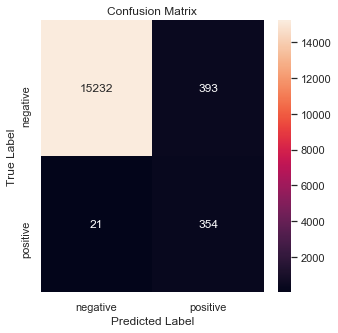

Number of False Positive =  393
Number of False Negative =  21
Total cost =  14430


14430

In [19]:
# model fitting using the best hyper parameter and predicting the cost
clf = XGBClassifier(max_depth= 6,  n_estimators= 18, n_jobs= -1, scale_pos_weight=40, min_child_weight=44)
clf.fit(train_median_imputed,y_train)
y_pred = clf.predict(test_median_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.1.2 Mean Imputed

In [20]:
# model fitting and hyper parameter tuning to find the best parameter

gsv.fit(train_mean_imputed,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.3min finished


Best HyperParameter:  {'max_depth': 3, 'n_estimators': 18}


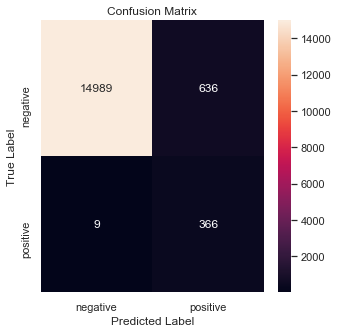

Number of False Positive =  636
Number of False Negative =  9
Total cost =  10860


10860

In [21]:
# model fitting using the best hyper parameter and predicting the cost
clf = XGBClassifier(max_depth= 3,  n_estimators= 18, n_jobs= -1, scale_pos_weight=40, min_child_weight=44)
clf.fit(train_mean_imputed,y_train)
y_pred = clf.predict(test_mean_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.1.3 Most Frequent Imputed

In [22]:
# model fitting and hyper parameter tuning to find the best parameter

gsv.fit(train_most_frequent_imputed,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.4min finished


Best HyperParameter:  {'max_depth': 6, 'n_estimators': 18}


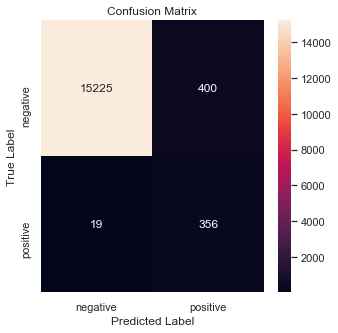

Number of False Positive =  400
Number of False Negative =  19
Total cost =  13500


13500

In [23]:
# model fitting using the best hyper parameter and predicting the cost
clf = XGBClassifier(max_depth= 6,  n_estimators= 18, n_jobs= -1, scale_pos_weight=40, min_child_weight=44)
clf.fit(train_most_frequent_imputed,y_train)
y_pred = clf.predict(test_most_frequent_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.1.4 Iterative Imputer

In [46]:
clf=XGBClassifier(scale_pos_weight=59)

depth=list(range(3, 10 ,3))
nEstimator = list(range(3, 20 ,3))
tuned_parameters = [{'max_depth':depth,'n_estimators':nEstimator}]

gsv = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsv.fit(train_iterative_imputed,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.2min finished


Best HyperParameter:  {'max_depth': 6, 'n_estimators': 15}


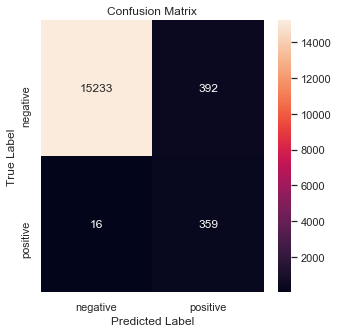

Number of False Positive =  392
Number of False Negative =  16
Total cost =  11920


11920

In [47]:
clf = XGBClassifier(max_depth= 6,  n_estimators= 15, n_jobs= -1, scale_pos_weight=40, min_child_weight=44)
clf.fit(train_iterative_imputed,y_train)
y_pred = clf.predict(test_iterative_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

## 5.2 Randomforest Classifier

### 5.2.1 Median Imputed

In [24]:
# model fitting and hyper parameter tuning to find the best parameter
clf=RandomForestClassifier(class_weight = 'balanced')

depth=list(range(3, 10 ,3))
nEstimator = list(range(3, 20 ,3))
tuned_parameters = [{'max_depth':depth,'n_estimators':nEstimator}]
gsvr = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsvr.fit(train_median_imputed,y_train)
print("Best HyperParameter: ",gsvr.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.0min finished


Best HyperParameter:  {'max_depth': 6, 'n_estimators': 18}


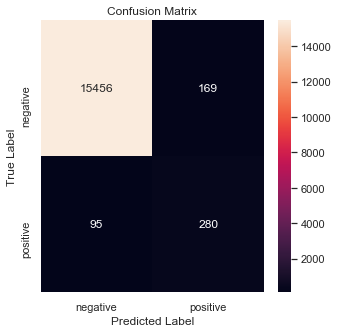

Number of False Positive =  169
Number of False Negative =  95
Total cost =  49190


49190

In [25]:
# model fitting using the best hyper parameter and predicting the cost
clf = RandomForestClassifier(n_estimators= 6 , max_depth=18, n_jobs= -1, class_weight = 'balanced')
clf.fit(train_median_imputed,y_train)
y_pred = clf.predict(test_median_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.2.2 Mean Imputed

In [26]:
gsvr.fit(train_mean_imputed,y_train)
print("Best HyperParameter: ",gsvr.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   60.0s finished


Best HyperParameter:  {'max_depth': 6, 'n_estimators': 15}


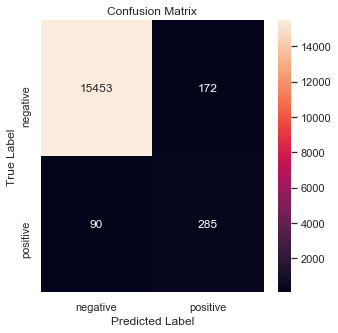

Number of False Positive =  172
Number of False Negative =  90
Total cost =  46720


46720

In [27]:
clf = RandomForestClassifier(n_estimators= 6 , max_depth=15,n_jobs= -1, class_weight = 'balanced')
clf.fit(train_mean_imputed,y_train)
y_pred = clf.predict(test_mean_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.2.3 Most Frequent Imputed

In [28]:
gsvr.fit(train_most_frequent_imputed,y_train)
print("Best HyperParameter: ",gsvr.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   60.0s finished


Best HyperParameter:  {'max_depth': 6, 'n_estimators': 18}


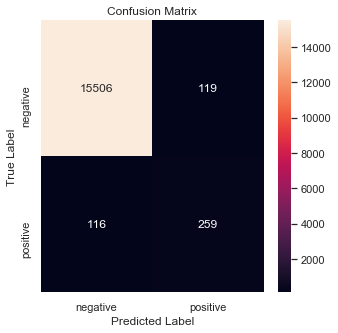

Number of False Positive =  119
Number of False Negative =  116
Total cost =  59190


59190

In [29]:
clf = RandomForestClassifier(n_estimators= 6 , max_depth=18,n_jobs= -1, class_weight = 'balanced')
clf.fit(train_most_frequent_imputed,y_train)
y_pred = clf.predict(test_most_frequent_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.2.4 Iterative Imputer

In [52]:
clf=RandomForestClassifier(class_weight = 'balanced')

depth=list(range(3, 10 ,3))
nEstimator = list(range(3, 20 ,3))
tuned_parameters = [{'max_depth':depth,'n_estimators':nEstimator}]
gsvr = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsvr.fit(train_iterative_imputed,y_train)
print("Best HyperParameter: ",gsvr.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.0min finished


Best HyperParameter:  {'max_depth': 6, 'n_estimators': 18}


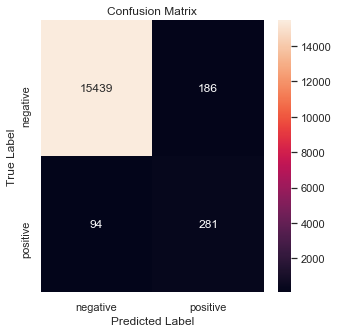

Number of False Positive =  186
Number of False Negative =  94
Total cost =  48860


48860

In [53]:
clf = RandomForestClassifier(n_estimators= 6 , max_depth=18, n_jobs= -1, class_weight = 'balanced')
clf.fit(train_iterative_imputed,y_train)
y_pred = clf.predict(test_iterative_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

## 5.3 Logistic Regression

### 5.3.1 Median Imputed

In [30]:
clf=LogisticRegression(penalty='l2', class_weight = 'balanced')

C_values = [10**x for x in range(-4,5)]
tuned_parameters = [{'C': C_values}]

gsvl = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsvl.fit(train_median_imputed,y_train)
print("Best HyperParameter: ",gsvl.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   41.1s finished


Best HyperParameter:  {'C': 0.0001}


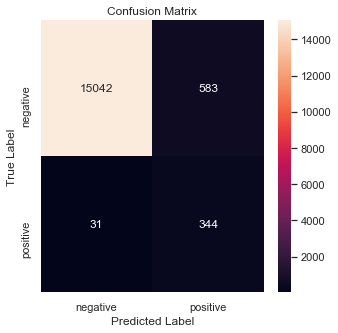

Number of False Positive =  583
Number of False Negative =  31
Total cost =  21330


21330

In [31]:
clf = LogisticRegression(penalty='l2', C=0.0001 ,n_jobs= -1, class_weight = 'balanced')
clf.fit(train_median_imputed,y_train)
y_pred = clf.predict(test_median_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.3.2 Mean Imputed

In [32]:
gsvl.fit(train_mean_imputed,y_train)
print("Best HyperParameter: ",gsvl.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   37.3s finished


Best HyperParameter:  {'C': 0.1}


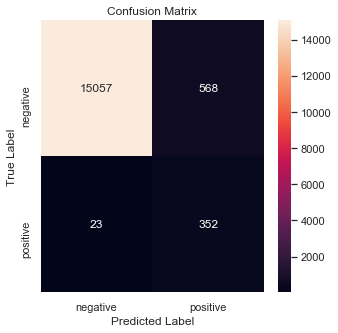

Number of False Positive =  568
Number of False Negative =  23
Total cost =  17180


17180

In [33]:
clf = LogisticRegression(penalty='l2', C=0.1 ,n_jobs= -1, class_weight = 'balanced')
clf.fit(train_mean_imputed,y_train)
y_pred = clf.predict(test_mean_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.3.3 Most Frequent Imputed

In [34]:
gsvl.fit(train_most_frequent_imputed,y_train)
print("Best HyperParameter: ",gsvl.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   39.9s finished


Best HyperParameter:  {'C': 0.01}


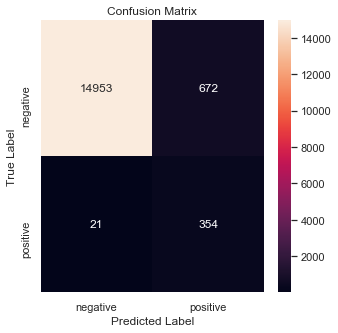

Number of False Positive =  672
Number of False Negative =  21
Total cost =  17220


17220

In [35]:
clf = LogisticRegression(penalty='l2', C=0.01 ,n_jobs= -1, class_weight = 'balanced')
clf.fit(train_most_frequent_imputed,y_train)
y_pred = clf.predict(test_most_frequent_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

### 5.3.4 Iterative Imputer

In [54]:
clf=LogisticRegression(penalty='l2', class_weight = 'balanced')

C_values = [10**x for x in range(-4,5)]
tuned_parameters = [{'C': C_values}]

gsvl = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsvl.fit(train_iterative_imputed,y_train)
print("Best HyperParameter: ",gsvl.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   37.9s finished


Best HyperParameter:  {'C': 1}


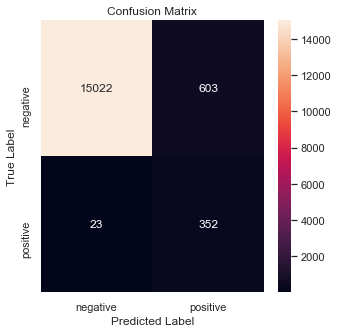

Number of False Positive =  603
Number of False Negative =  23
Total cost =  17530


17530

In [55]:
clf = LogisticRegression(penalty='l2', C=1 ,n_jobs= -1, class_weight = 'balanced')
clf.fit(train_iterative_imputed,y_train)
y_pred = clf.predict(test_iterative_imputed)
cm =confusion_matrix (y_test, y_pred)
result(cm)

# 6. Feature Engineering

## 6.1 Removing Correlated Features

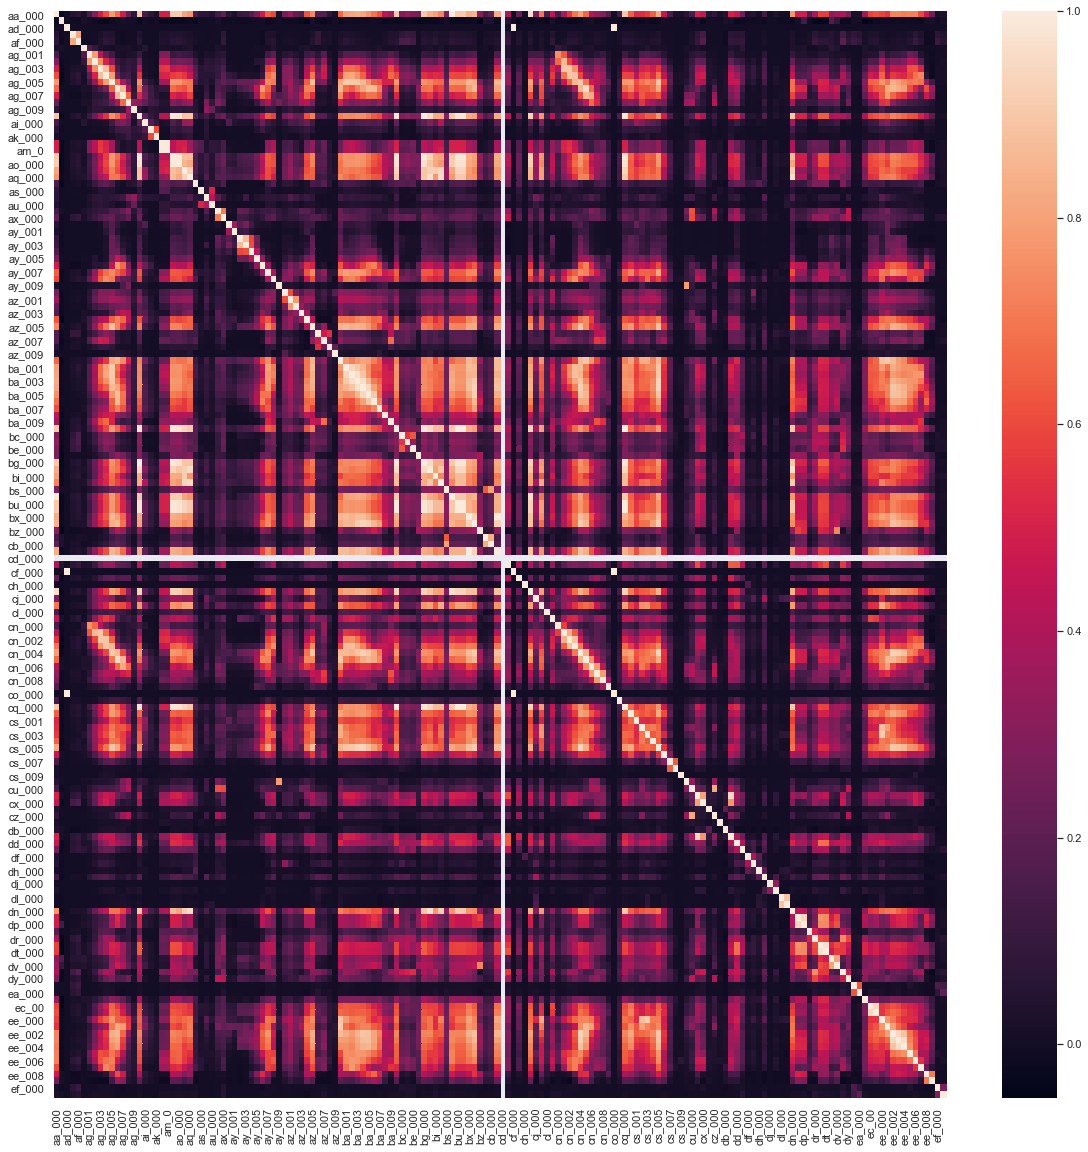

In [36]:
#Plotting heat map for feature correlation from correlation matrix
corr_matrix = train_mean_imputed.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corr_matrix, annot=False)
plt.show()

Observation: The above plot shows the degree of correlation among features

In [37]:
#Setting correlation coefficient threshold as 0.8 to remove highly correlated features in train data
#Reference: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.8)]
train_imp_features = train_mean_imputed.drop(train_mean_imputed[to_drop], axis=1)
train_imp_features.head()

,ac_000,af_000,ag_000,ag_001,ag_008,ag_009,ai_000,aj_000,ak_000,am_0,...,ee_000,ee_001,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,2.130706e+09,0.0,0.0,0.0,25896.0,0.0,0.0,0.0,0.0,0.0,...,965866.0,1706908.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.000000e+00,0.0,0.0,0.0,31642.0,0.0,0.0,68.0,0.0,0.0,...,664504.0,824154.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,2.280000e+02,0.0,0.0,0.0,12016.0,0.0,0.0,0.0,0.0,0.0,...,262032.0,453378.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,7.000000e+01,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3894.0,...,5670.0,1566.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,1.368000e+03,0.0,0.0,0.0,4588.0,0.0,0.0,226.0,0.0,0.0,...,404740.0,904230.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [38]:
test_imp_features = test_mean_imputed.drop(test_mean_imputed[to_drop], axis=1)
test_imp_features.head()

,ac_000,af_000,ag_000,ag_001,ag_008,ag_009,ai_000,aj_000,ak_000,am_0,...,ee_000,ee_001,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2374.0,...,7502.0,3156.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0
1,68.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,...,10040.0,3310.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0
2,212.0,0.0,0.0,0.0,520.0,0.0,0.0,0.0,0.0,110548.0,...,396312.0,538136.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0
3,1010.0,0.0,0.0,0.0,92606.0,14038.0,0.0,0.0,0.0,2372.0,...,659550.0,691580.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0
4,156.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10216.0,9958.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0


## 6.2 XGBoost Classifier after removing correlated features

In [39]:
# model fitting and hyper parameter tuning to find the best parameter
clf=XGBClassifier(scale_pos_weight=59)

depth=list(range(3, 10 ,3))
nEstimator = list(range(3, 20 ,3))
tuned_parameters = [{'max_depth':depth,'n_estimators':nEstimator}]

gsv = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsv.fit(train_imp_features,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.3min finished


Best HyperParameter:  {'max_depth': 3, 'n_estimators': 18}


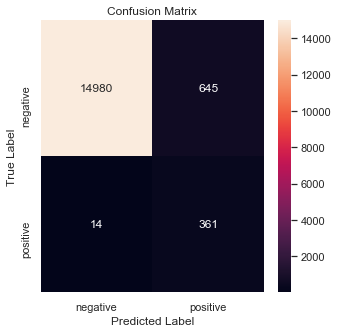

Number of False Positive =  645
Number of False Negative =  14
Total cost =  13450


13450

In [40]:
# model fitting using the best hyper parameter and predicting the cost
clf = XGBClassifier(max_depth=3,  n_estimators= 18, n_jobs= -1, scale_pos_weight=40,min_child_weight=44)
clf.fit(train_imp_features,y_train)
y_pred = clf.predict(test_imp_features)
cm =confusion_matrix (y_test, y_pred)
result(cm)

## 6.3 Randomforest Classifier after removing correlated features

In [41]:
# model fitting and hyper parameter tuning to find the best parameter
clf=RandomForestClassifier(class_weight = 'balanced')

depth=list(range(3, 10 ,1))
nEstimator = list(range(3, 10 ,3))
tuned_parameters = [{'max_depth':depth,'n_estimators':nEstimator}]
gsvr = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsvr.fit(train_imp_features,y_train)
print("Best HyperParameter: ",gsvr.best_params_)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:   29.6s finished


Best HyperParameter:  {'max_depth': 7, 'n_estimators': 9}


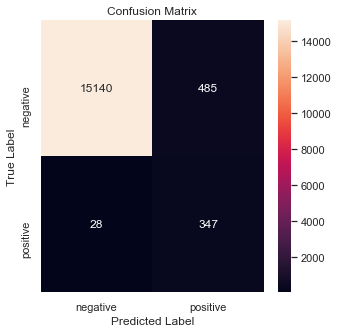

Number of False Positive =  485
Number of False Negative =  28
Total cost =  18850


18850

In [42]:
# model fitting using the best hyper parameter and predicting the cost
clf = RandomForestClassifier(max_depth=7,n_estimators =9, n_jobs= -1,class_weight = 'balanced')
clf.fit(train_imp_features,y_train)
y_pred = clf.predict(test_imp_features)
cm =confusion_matrix (y_test, y_pred)
result(cm)

## 6.4 Logistic Regression Classifier after removing correlated features

In [43]:
clf=LogisticRegression(penalty='l2', class_weight = 'balanced')

C_values = [10**x for x in range(-4,5)]
tuned_parameters = [{'C': C_values}]

gsvl = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsvl.fit(train_imp_features,y_train)
print("Best HyperParameter: ",gsvl.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   28.1s finished


Best HyperParameter:  {'C': 1000}


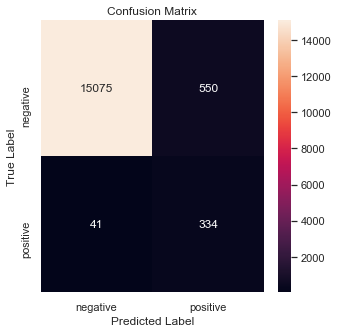

Number of False Positive =  550
Number of False Negative =  41
Total cost =  26000


26000

In [44]:
clf = LogisticRegression(penalty='l2', C=1000 ,n_jobs= -1, class_weight = 'balanced')
clf.fit(train_imp_features,y_train)
y_pred = clf.predict(test_imp_features)
cm =confusion_matrix (y_test, y_pred)
result(cm)

# 7. Feature Engineering 

In [27]:
#Got inspired by missing indicator imputation technique in the folloing blog.
#Credits - https://medium.com/swlh/aps-failure-at-scania-trucks-203975cdc2dd

#New features are generated by indicating true where there is a missing value and false in non missing value of given train and test data.

In [45]:
#Generating new features
missing_indicator = MissingIndicator()
train_missing_indicator = missing_indicator.fit_transform(train)
train_missing = pd.DataFrame(train_missing_indicator)

In [46]:
train_missing.head()

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
test_missing_indicator = missing_indicator.fit_transform(test)
test_missing = pd.DataFrame(test_missing_indicator)

train_features= train_mean_imputed
test_features = test_mean_imputed

In [48]:
# Concatinating mean imputed features and new features
train_features[train_missing.columns] = train_missing
test_features[test_missing.columns] = test_missing

In [49]:
train_features.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,149,150,151,152,153,154,155,156,157,158
0,76698.0,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,...,False,False,False,False,False,False,False,False,False,False
1,33058.0,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,...,False,False,False,False,False,False,False,False,False,False
2,41040.0,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,...,False,False,False,False,False,False,False,False,False,False
3,12.0,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,...,False,False,False,False,False,False,False,False,False,False
4,60874.0,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,...,False,False,False,False,False,False,False,False,False,False


## 7.1 XGBoost after Feature Engineering

In [50]:
clf=XGBClassifier(scale_pos_weight=59)

depth=list(range(3, 10 ,3))
nEstimator = list(range(3, 20 ,3))
tuned_parameters = [{'max_depth':depth,'n_estimators':nEstimator}]

gsv = GridSearchCV(clf,tuned_parameters,cv=3,verbose=1,scoring='roc_auc', return_train_score=True, n_jobs=-1)
gsv.fit(train_features,y_train)
print("Best HyperParameter: ",gsv.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  7.8min finished


Best HyperParameter:  {'max_depth': 6, 'n_estimators': 18}


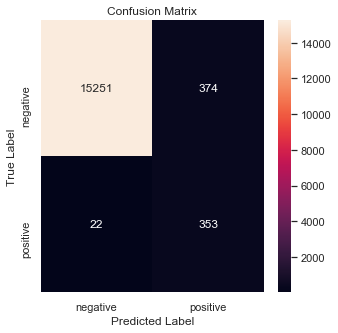

Number of False Positive =  374
Number of False Negative =  22
Total cost =  14740


14740

In [51]:
clf = XGBClassifier(max_depth= 6,  n_estimators= 18, n_jobs= -1, scale_pos_weight=40, min_child_weight=44)
clf.fit(train_features,y_train)
y_pred = clf.predict(test_features)
cm =confusion_matrix (y_test, y_pred)
result(cm)

# 8. Conclusion

In [56]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Cost"]


x.add_row(["XGBoost - Median Imputed", "14430"])
x.add_row(["XGBoost - Mean Imputed", "10860"])
x.add_row(["XGBoost - Most Frequent Imputed", "13500"])
x.add_row(["XGBoost - Iterative Imputed", "11920"])
x.add_row(["********************************************************", "*******"])
x.add_row(["Random Forest - Median Imputed", "49190"])
x.add_row(["Random Forest - Mean Imputed", "46720"])
x.add_row(["Random Forest - Most Frequent Imputed", "59190"])
x.add_row(["Random Forest - Iterative Imputed", "48860"])
x.add_row(["********************************************************", "*******"])
x.add_row(["Logistic Regression - Median Imputed", "21330"])
x.add_row(["Logistic Regression - Mean Imputed", "17180"])
x.add_row(["Logistic Regression - Most Frequent Imputed", "17220"])
x.add_row(["Logistic Regression - Iterative Imputed", "17530"])
x.add_row(["********************************************************", "*******"])
x.add_row(["XGBoost after removing correlated features", "13450"])
x.add_row(["Randomforest after removing correlated features", "18850"])
x.add_row(["Logistic Regression after removing correlated features", "26000"])
x.add_row(["********************************************************", "*******"])
x.add_row(["XGBoost after feature engineering", "14740"])


print(x)

+----------------------------------------------------------+---------+
|                          Model                           |   Cost  |
+----------------------------------------------------------+---------+
|                 XGBoost - Median Imputed                 |  14430  |
|                  XGBoost - Mean Imputed                  |  10860  |
|             XGBoost - Most Frequent Imputed              |  13500  |
|               XGBoost - Iterative Imputed                |  11920  |
| ******************************************************** | ******* |
|              Random Forest - Median Imputed              |  49190  |
|               Random Forest - Mean Imputed               |  46720  |
|          Random Forest - Most Frequent Imputed           |  59190  |
|            Random Forest - Iterative Imputed             |  48860  |
| ******************************************************** | ******* |
|           Logistic Regression - Median Imputed           |  21330  |
|     

Obesrvations:

1. Different imputation techniques have been tried. As mean imputed data gives best results, this is used for further analysis.
2. Feature Selection - Highly correlated features have been removed and ML Algorithms are applied. 
3. Feature Engineering - New features that indicate missing values of train and test data are added to mean imputed features. Xgboost technique is applied to new concatinated features.
4. It is observed that Mean imputaion with XGboost gives the best results